# Exploratory Data Analysis
Exploratory data analysis for the [UCI dataset](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008). The dataset represents ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks.

Each row concerns hospital records of patients diagnosed with diabetes, who underwent laboratory, medications, and stayed up to 14 days. The goal is to determine the **early readmission of the patient within 30 days of discharge**.

The problem is important for the following reasons. Despite high-quality evidence showing improved clinical outcomes for diabetic patients who receive various preventive and therapeutic interventions, many patients do not receive them. This can be partially attributed to arbitrary diabetes management in hospital environments, which fail to attend to glycemic control. Failure to provide proper diabetes care not only increases the managing costs for the hospitals (as the patients are readmitted) but also impacts the morbidity and mortality of the patients, who may face complications associated with diabetes.

## **0. Initial Setup**
Taking care of package imports, defining work constants, and loading all necessary datasets.

### 0.1 Python imports

In [40]:
# Data Analysis
import numpy as np
import pandas as pd
import scipy as sp

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Miscellaneous
import random
import time

# Visualization configurations
pd.set_option('display.max_columns', 50)
plt.style.use('ggplot')
sns.set_style('white')

### 0.2 Constants

In [41]:
DATA_PATH = '../data/'

RANDOM_STATE = 38

### 0.3 Loading datasets

In [42]:
diabetic_data = pd.read_csv(
    DATA_PATH + 'diabetic_data.csv',
    index_col='encounter_id',
    na_values='?',
    keep_default_na=False
)

/tmp/ipykernel_5055/3483556448.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  diabetic_data = pd.read_csv(


## **1. Data Understanding**
Exploring the nature of the dataset.

- Database shape (entries and features)
- Database head and tail
- Feature types (dtypes)
- Feature distribution (describe)

### 1.0 Dataset structure

In [43]:
diabetic_data.sample(10)

,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
encounter_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
71005992,17048637,AfricanAmerican,Male,[60-70),NaN,1,1,7,2,NaN,NaN,40,0,10,0,0,0,786,780,250,4,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
145374924,88149285,Caucasian,Male,[50-60),NaN,1,2,7,1,BC,NaN,49,0,7,0,0,0,577,276,276,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,<30
332621036,138876449,Caucasian,Female,[60-70),NaN,3,6,1,12,MD,NaN,45,2,27,0,0,0,162,198,496,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,Steady,No,No,No,No,Ch,Yes,NO
120921528,23299236,AfricanAmerican,Female,[80-90),NaN,1,3,5,14,MC,Nephrology,41,5,21,4,1,2,557,535,403,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,<30
170496132,89247339,AfricanAmerican,Male,[40-50),NaN,1,1,7,5,NaN,NaN,43,0,9,1,0,1,403,276,250.4,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO
270341688,30689766,Other,Female,[60-70),NaN,2,1,7,1,MD,Emergency/Trauma,42,0,4,4,1,0,786,719,719,9,None,>8,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
192965130,83240973,AfricanAmerican,Male,[60-70),NaN,2,13,1,1,CP,Gastroenterology,20,1,15,0,0,0,155,285,250,5,None,None,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
127078848,24800184,AfricanAmerican,Male,[50-60),NaN,3,1,1,3,MD,Nephrology,29,3,29,0,0,0,428,403,250.4,4,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
117528846,56771919,Caucasian,Male,[60-70),NaN,2,1,4,3,NaN,NaN,28,4,14,0,0,0,414,411,272,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO


Checking columns dtypes

In [44]:
diabetic_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101766 entries, 2278392 to 443867222
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   patient_nbr               101766 non-null  int64 
 1   race                      99493 non-null   object
 2   gender                    101766 non-null  object
 3   age                       101766 non-null  object
 4   weight                    3197 non-null    object
 5   admission_type_id         101766 non-null  int64 
 6   discharge_disposition_id  101766 non-null  int64 
 7   admission_source_id       101766 non-null  int64 
 8   time_in_hospital          101766 non-null  int64 
 9   payer_code                61510 non-null   object
 10  medical_specialty         51817 non-null   object
 11  num_lab_procedures        101766 non-null  int64 
 12  num_procedures            101766 non-null  int64 
 13  num_medications           101766 non-null  int64 
 14  

In [45]:
diabetic_data.isnull().sum().sort_values(ascending=False)

weight                      98569
medical_specialty           49949
payer_code                  40256
race                         2273
diag_3                       1423
diag_2                        358
diag_1                         21
admission_type_id               0
patient_nbr                     0
time_in_hospital                0
admission_source_id             0
num_lab_procedures              0
num_procedures                  0
num_medications                 0
discharge_disposition_id        0
gender                          0
age                             0
number_inpatient                0
number_emergency                0
number_outpatient               0
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide     

Since we are primarily interested in factors that lead to early readmission, we defined the readmission attribute (outcome) as having two values: `readmitted`, if the patient was readmitted within 30 days of discharge or `otherwise`, which covers both readmission after 30 days and no readmission at all.

In [46]:
# diabetic_data['readmitted'] = diabetic_data['readmitted'].replace(
#     {
#         '<30': 'readmitted',
#         'NO': 'otherwise',
#         '>30': 'otherwise'
#     }
# )

In [47]:
def map_icd9_codes(icd9_code):
    # Handle missing values
    if pd.isnull(icd9_code):
        return None

    # Handle special ICD-9 codes (E-V)
    try:
        code = float(icd9_code)
    except ValueError:
        return 'Other'

    if 390 <= code <= 459:
        return 'Circulatory'
    elif 460 <= code <= 519:
        return 'Respiratory'
    elif 520 <= code <= 579:
        return 'Digestive'
    elif 250 <= code < 251:
        return 'Diabetes'
    elif 800 <= code <= 999:
        return 'Injury'
    elif 710 <= code <= 739:
        return 'Musculoskeletal'
    elif 580 <= code <= 629:
        return 'Genitourinary'
    elif 140 <= code <= 239:
        return 'Neoplasms'
    else:
        return 'Other'

In [48]:
def map_admission_source(admission_src_id):
    # Handle missing values
    if pd.isnull(admission_src_id):
        return None
    
    if admission_src_id in [1, 2, 3]:
        return 'Referral'
    elif admission_src_id in [4, 5, 6, 10, 18, 22, 25, 26]:
        return 'Transfer from Another Facility'
    elif admission_src_id in [7, 8]:
        return 'Emergency or Law Enforcement'
    else:
        return 'Other'

In [49]:
def map_discharge_disposition(discharge_disp_id):
    # Handle missing values
    if pd.isnull(discharge_disp_id):
        return None
    
    if discharge_disp_id in [1, 6, 8]:
        return 'Home / Home Care'
    elif discharge_disp_id in [2, 3, 4, 5, 10, 15, 16, 17, 22, 23, 24, 27, 28, 29, 30]:
        return 'Transfer to Another Facility'
    elif discharge_disp_id in [11, 19, 20, 21]:
        return 'Expired'
    elif discharge_disp_id in [13, 14]:
        return 'Hospice Care'
    else:
        return 'Other'

In [50]:
def map_medical_specialty(medical_specialty):
    # Handle missing values
    if pd.isnull(medical_specialty):
        return None
    
    if medical_specialty == 'InternalMedicine':
        return 'Internal Medicine'
    
    elif medical_specialty == 'Family/GeneralPractice':
        return 'Family/General Practice'
    
    elif medical_specialty == 'Emergency/Trauma':
        return 'Emergency/Trauma'
    
    elif medical_specialty in [
        'Surgeon', 'Surgery-Colon&Rectal',
        'Surgery-General', 'Surgery-Maxillofacial', 'Surgery-Neuro',
        'Surgery-Pediatric', 'Surgery-Plastic',
        'Surgery-PlasticwithinHeadandNeck', 'Surgery-Thoracic',
        'Surgery-Vascular', 'SurgicalSpecialty'
    ]:
        return 'Surgery'
    
    elif medical_specialty in [
        'Cardiology', 'Surgery-Cardiovascular',
        'Surgery-Cardiovascular/Thoracic'
    ]:
        return 'Cardiology'
    
    else:
        return 'Other'

## **2. Preprocessing**

### 2.0 Functions

### 2.1 Data Pre-Cleanup

#### 2.1.2 Duplicates
Looking for duplicate instances, by excluding the reference to the patient and encounter identifiers. Luckily, there are none of them.

In [51]:
temp_data = diabetic_data.drop(columns=['patient_nbr'])
duplicates = temp_data[temp_data.duplicated()]
duplicates

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
encounter_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


### 2.2 Feature Engineering

#### 1.2.1 Diagnoses

Mapping **diag_1**, **diag_2** and **diag_3** in macro-categories.

In [52]:
diabetic_data['diag_1_group'] = diabetic_data['diag_1'].apply(map_icd9_codes)
diabetic_data['diag_2_group'] = diabetic_data['diag_2'].apply(map_icd9_codes)
diabetic_data['diag_3_group'] = diabetic_data['diag_3'].apply(map_icd9_codes)

#### 1.2.2 Admission sources

Mapping **admission_source_id** in macro-categories.
**USE K-Nearest Neighbor to approximate missing values (Not Available, Not Mapped, NULL)**

Not Available e null sono identici, in entrambi i casi il valore non è disponibile.

Not Mapped può avere un significato diverso, nel senso che il valore non è stato preso perché non importante.

In [53]:
diabetic_data['admission_source_id'].value_counts().sort_values(ascending=False)

admission_source_id
7     57494
1     29565
17     6781
4      3187
6      2264
2      1104
5       855
3       187
20      161
9       125
8        16
22       12
10        8
14        2
11        2
25        2
13        1
Name: count, dtype: int64

In [54]:
diabetic_data['admission_source_group'] = diabetic_data['admission_source_id'].apply(map_admission_source)

#### 1.2.3 Discharge dispositions

Mapping **discharge_disposition_id** in macro-categories. **MAY REQUIRE to remove all patients that died from the dataset... maybe also those sent to hospices.**

In [55]:
diabetic_data['discharge_disposition_id'].value_counts().sort_values(ascending=False)

discharge_disposition_id
1     60234
3     13954
6     12902
18     3691
2      2128
22     1993
11     1642
5      1184
25      989
4       815
7       623
23      412
13      399
14      372
28      139
8       108
15       63
24       48
9        21
17       14
16       11
19        8
10        6
27        5
12        3
20        2
Name: count, dtype: int64

In [56]:
diabetic_data['discharge_disposition_group'] = diabetic_data['discharge_disposition_id'].apply(map_discharge_disposition)

#### 1.2.4 Medical specialties

Mapping **medical_specialty** to macro-categories.

In [57]:
diabetic_data['medical_specialty'].sort_values(ascending=True).unique()

array(['AllergyandImmunology', 'Anesthesiology',
       'Anesthesiology-Pediatric', 'Cardiology', 'Cardiology-Pediatric',
       'DCPTEAM', 'Dentistry', 'Dermatology', 'Emergency/Trauma',
       'Endocrinology', 'Endocrinology-Metabolism',
       'Family/GeneralPractice', 'Gastroenterology', 'Gynecology',
       'Hematology', 'Hematology/Oncology', 'Hospitalist',
       'InfectiousDiseases', 'InternalMedicine', 'Nephrology',
       'Neurology', 'Neurophysiology',
       'Obsterics&Gynecology-GynecologicOnco', 'Obstetrics',
       'ObstetricsandGynecology', 'Oncology', 'Ophthalmology',
       'Orthopedics', 'Orthopedics-Reconstructive', 'Osteopath',
       'Otolaryngology', 'OutreachServices', 'Pathology', 'Pediatrics',
       'Pediatrics-AllergyandImmunology', 'Pediatrics-CriticalCare',
       'Pediatrics-EmergencyMedicine', 'Pediatrics-Endocrinology',
       'Pediatrics-Hematology-Oncology', 'Pediatrics-InfectiousDiseases',
       'Pediatrics-Neurology', 'Pediatrics-Pulmonology', 'Per

In [58]:
diabetic_data['medical_specialty_group'] = diabetic_data['medical_specialty'].apply(map_medical_specialty)

#### 1.2.5 Diabetes medication and changes

In [94]:
# Making change and subministration of diabetes medication boolean
diabetic_data['change'] = diabetic_data['change'].replace(
    {
        'No': 0,
        'Ch': 1
    }
)
diabetic_data['diabetesMed'] = diabetic_data['diabetesMed'].replace(
    {
        'No': 0,
        'Yes': 1
    }
)

# Renaming features
diabetic_data = diabetic_data.rename(columns={
    'change': 'diabetes_med_change',
    'diabetesMed': 'diabetes_med_provided'
})

#### 1.2.6 Medications

Convert subministration or not subministration of medications into boolean values.

In [100]:
diabetic_data.loc[:, 'metformin':'metformin-pioglitazone'] = diabetic_data.loc[:, 'metformin':'metformin-pioglitazone'].replace(
    {
        'No': 0,
        'Steady': 1,
        'Up': 1,
        'Down': 1
    }
)

/tmp/ipykernel_5055/783719850.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  diabetic_data.loc[:, 'metformin':'metformin-pioglitazone'] = diabetic_data.loc[:, 'metformin':'metformin-pioglitazone'].replace(


Group all medications of the same type.

In [108]:
# Sulfonylureas
diabetic_data['sulfonylureas'] = diabetic_data[['chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'tolbutamide', 'tolazamide']].any(axis=1)

### 2.3 Data Post-Cleanup

#### 2.3.1 Expired patients
Removing all expired (dead) patients, since they do not count towards readmission.

In [59]:
diabetic_data = diabetic_data[
    diabetic_data['discharge_disposition_group'] != 'Expired'
]

## **2. Visual Analysis**
Work in progress... the estimated date of completion is also work in progress LoL

### 2.0 Functions

In [60]:
def heatmap_crosstab(
        data: pd.DataFrame,
        x: str, y: str,
        rows: pd.Index | None = None,
        columns: pd.Index | None = None
):
    """
    Counts occurrences of each combination of categories between two variables,
    then visualize it using a heatmap.
    """
    # Create the crosstab with the specific column order
    crosstab = pd.crosstab(data[y], data[x])
    crosstab = crosstab.reindex(index=rows, columns=columns)

    # Normalize the crosstab to get column-wise percentages
    crosstab_percent = crosstab.div(crosstab.sum(axis=0), axis=1) * 100

    # Create an annotation matrix combining counts and percentages
    annotations = np.empty(crosstab.shape, dtype=object)
    for i in range(crosstab.shape[0]):
        for j in range(crosstab.shape[1]):
            count = crosstab.iloc[i, j]
            percent = crosstab_percent.iloc[i, j]

            if pd.isna(count) or pd.isna(percent):
                annotations[i, j] = 'N/A'
            else:
                annotations[i, j] = f'{count}\n({percent:.2f}%)' 

    # Plot the heatmap
    return sns.heatmap(
        crosstab_percent,
        annot=annotations,
        cmap="YlGnBu",
        fmt=''
    )

### 2.1 Univariate
Exploring the distribution of values for each feature.

#### 2.1.1 Non-medication features

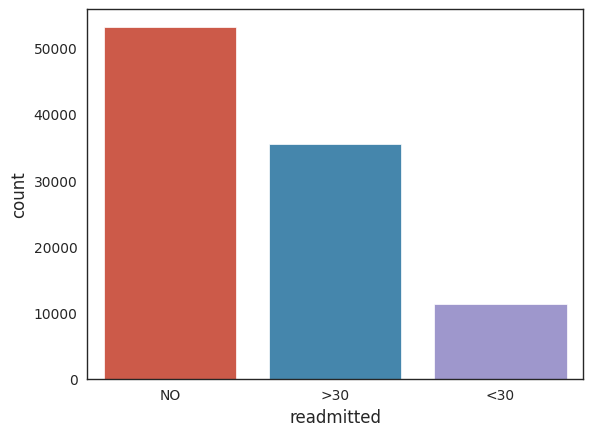

In [61]:
sns.countplot(data=diabetic_data, x='readmitted', hue='readmitted', legend=None)
plt.show()

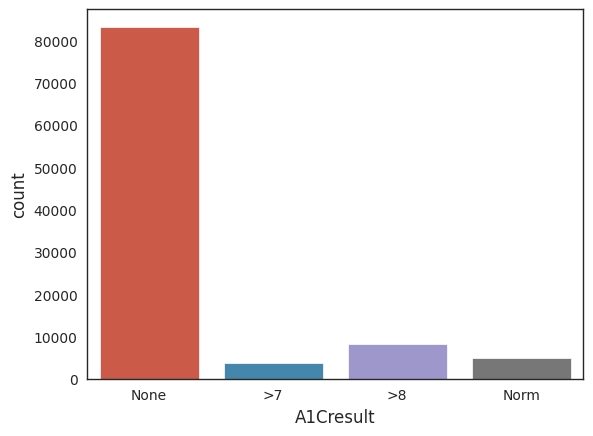

In [62]:
sns.countplot(data=diabetic_data, x='A1Cresult', hue='A1Cresult', legend=None)
plt.show()

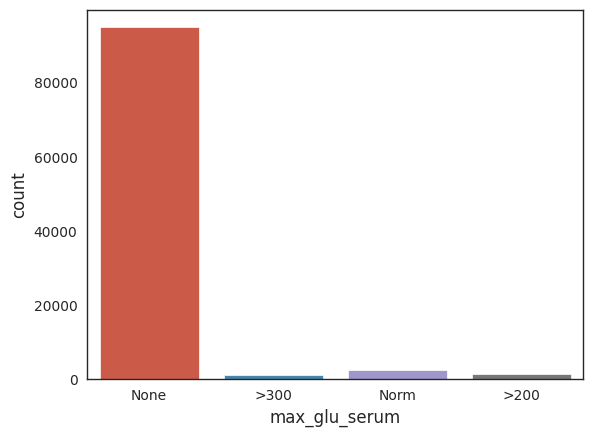

In [63]:
sns.countplot(data=diabetic_data, x='max_glu_serum', hue='max_glu_serum', legend=None)
plt.show()

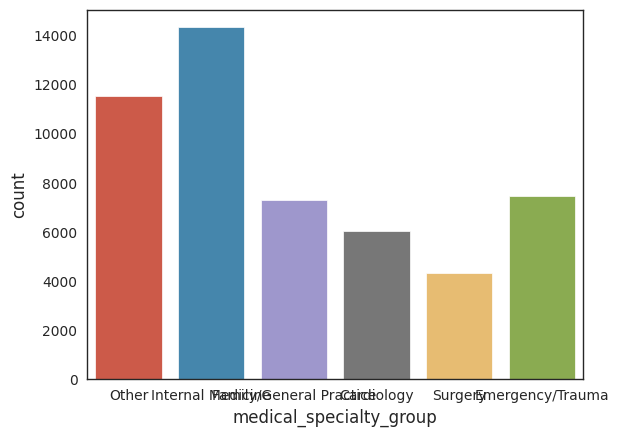

In [64]:
sns.countplot(data=diabetic_data, x='medical_specialty_group', hue='medical_specialty_group', legend=None)
plt.show()

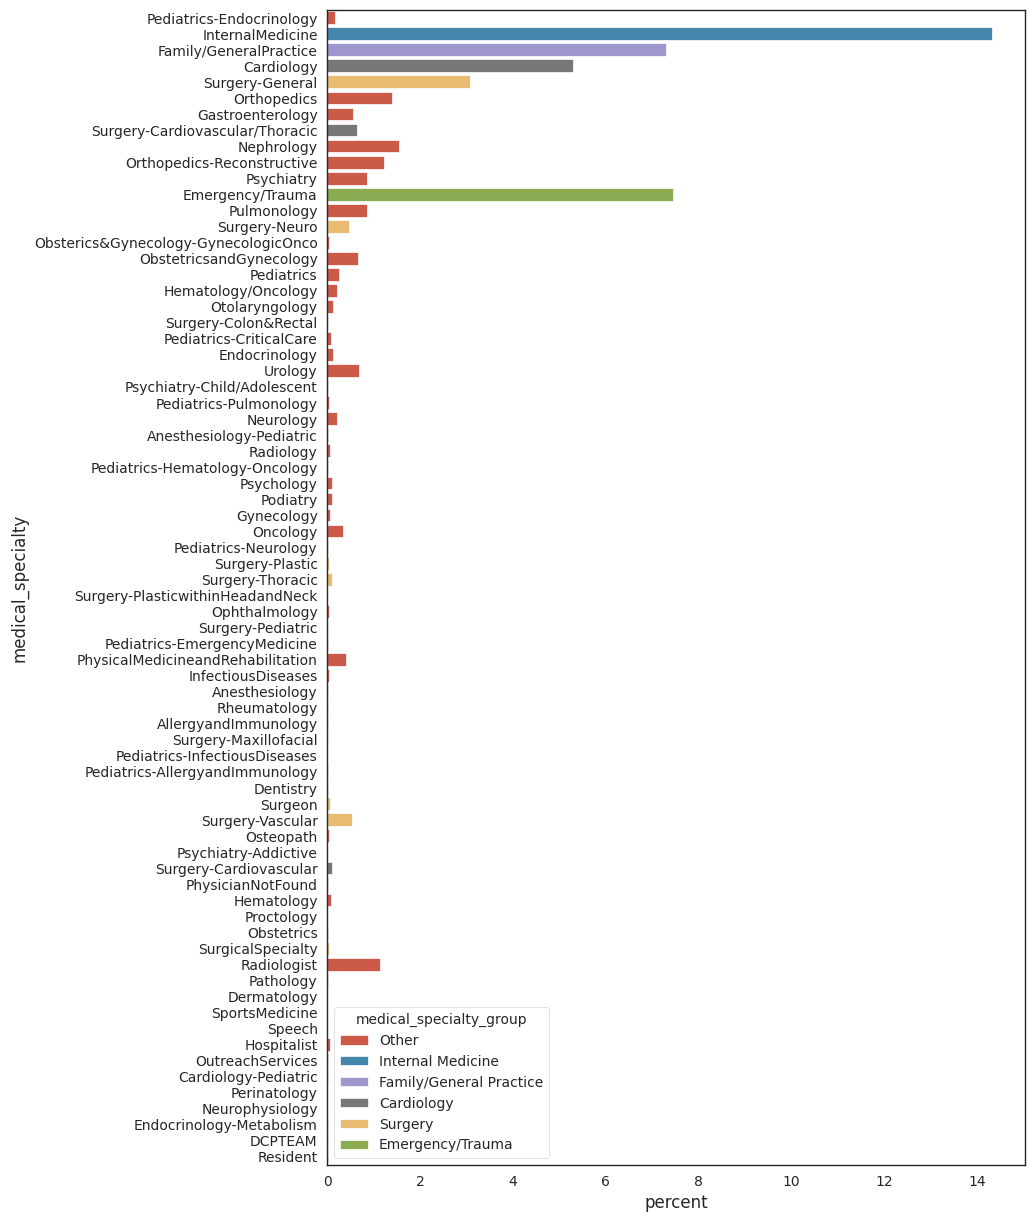

In [65]:
plt.figure(figsize=(9, 15))
sns.countplot(
    data=diabetic_data,
    y='medical_specialty',
    hue='medical_specialty_group',
    stat='percent'
)
plt.show()

#### 2.1.2 Medication features

### 2.2 Multivariate with Readmission
Exploring the relationship of multiple features with readmission status.

#### 2.2.1 Non-medication features

For **A1Cresult**, there doesn't seem to be any direct visible relationship with the readmissions.

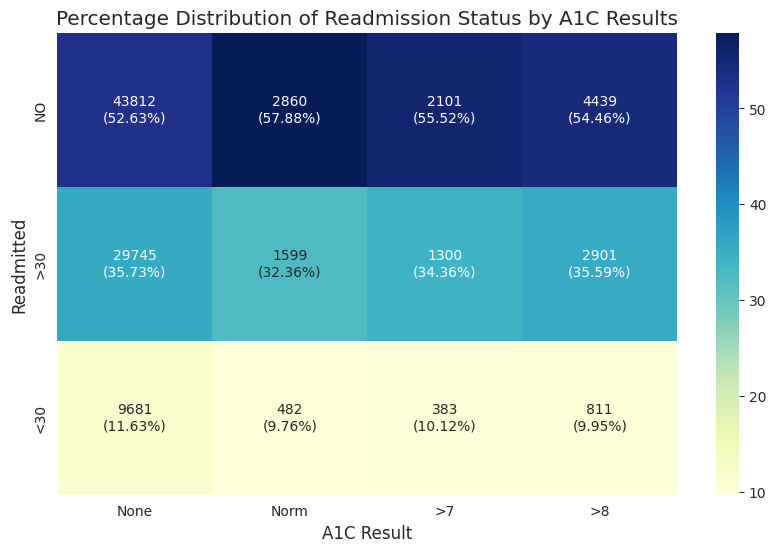

In [66]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='A1Cresult',
    y='readmitted',
    rows=['NO', '>30', '<30'],
    columns=['None', 'Norm', '>7', '>8']
)

plt.title('Percentage Distribution of Readmission Status by A1C Results')
plt.xlabel('A1C Result')
plt.ylabel('Readmitted')
plt.show()

For **max_glu_serum**, there is a visible direct correlation with readmission rates. For people that were readmitted within 30 days, but also for those readmitted after 30 days, readmission rates increase with the increase of glucose. For all those people that were not readmitted, there is an inverse relationship with the increase of glucose levels.

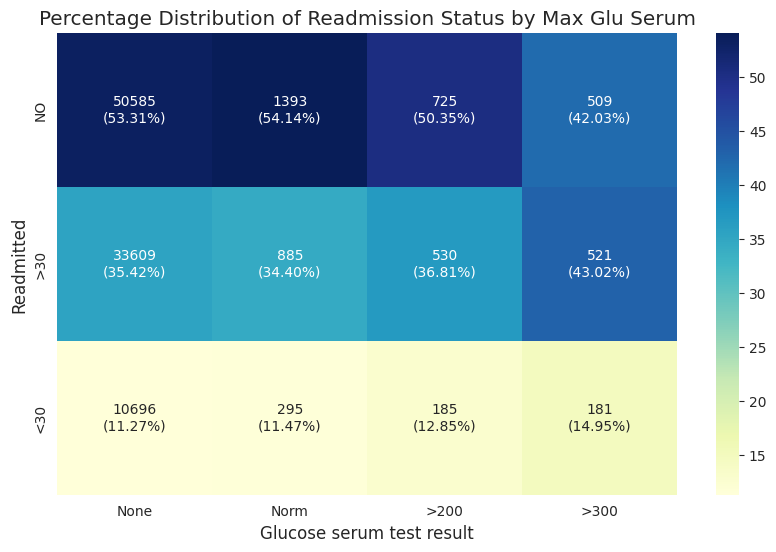

In [67]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='max_glu_serum',
    y='readmitted',
    rows=['NO', '>30', '<30'],
    columns=['None', 'Norm', '>200', '>300']
)

plt.title('Percentage Distribution of Readmission Status by Max Glu Serum')
plt.xlabel('Glucose serum test result')
plt.ylabel('Readmitted')
plt.show()

For **age**, there is a very slight correlation with readmission rates. Percentage of readmitted people, both for <30 and >30, is directly proportional up to 20 years. After the 20s, we notice an attenuation of values, meaning that the readmission percentage does not increase as the age increases, but remains stable.

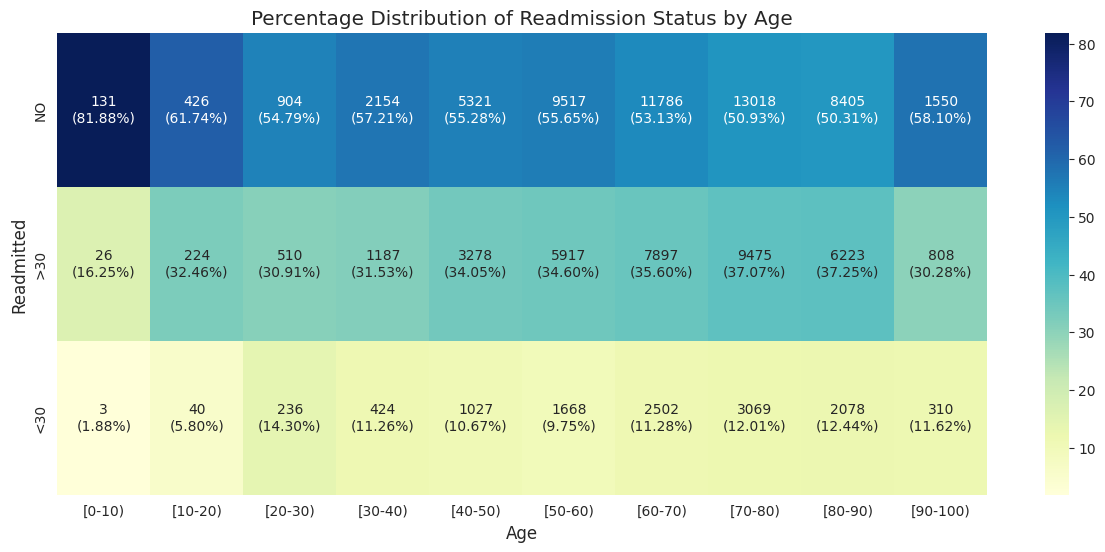

In [68]:
plt.figure(figsize=(15, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='age',
    y='readmitted',
    rows=['NO', '>30', '<30'],
    columns=[
        '[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)',
        '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)'
    ]
)

plt.title('Percentage Distribution of Readmission Status by Age')
plt.xlabel('Age')
plt.ylabel('Readmitted')
plt.show()

For both **gender** and **race**, there is no visible correlation with readmissions. _Too bad, we can't make racist elmo._ 👀

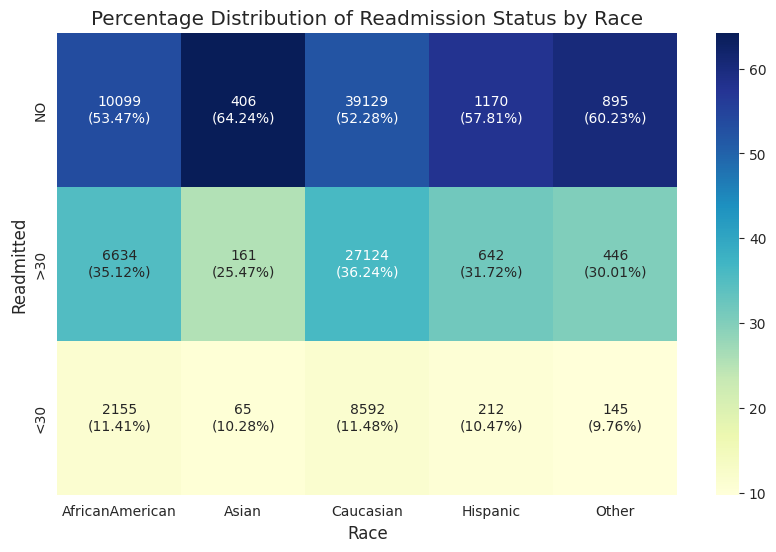

In [69]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='race',
    y='readmitted',
    rows=['NO', '>30', '<30'],
    # columns=['No', 'Down', 'Steady', 'Up']
)

plt.title('Percentage Distribution of Readmission Status by Race')
plt.xlabel('Race')
plt.ylabel('Readmitted')
plt.show()

For **num_medications**, there is no visible correlation with readmission.

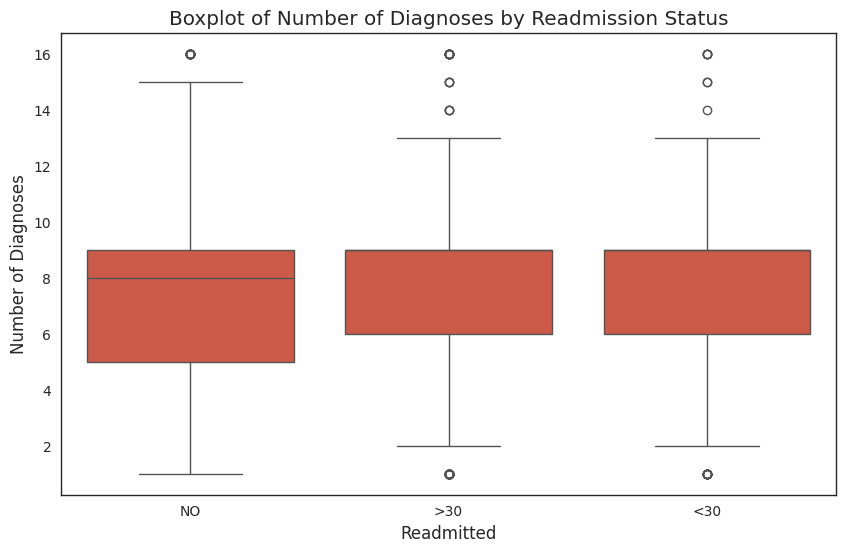

In [70]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=diabetic_data, x='readmitted', y='number_diagnoses')

# Add labels and title
plt.title('Boxplot of Number of Diagnoses by Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('Number of Diagnoses')

# Show the plot
plt.show()

For **num_medications**, there is no visible correlation with readmission.

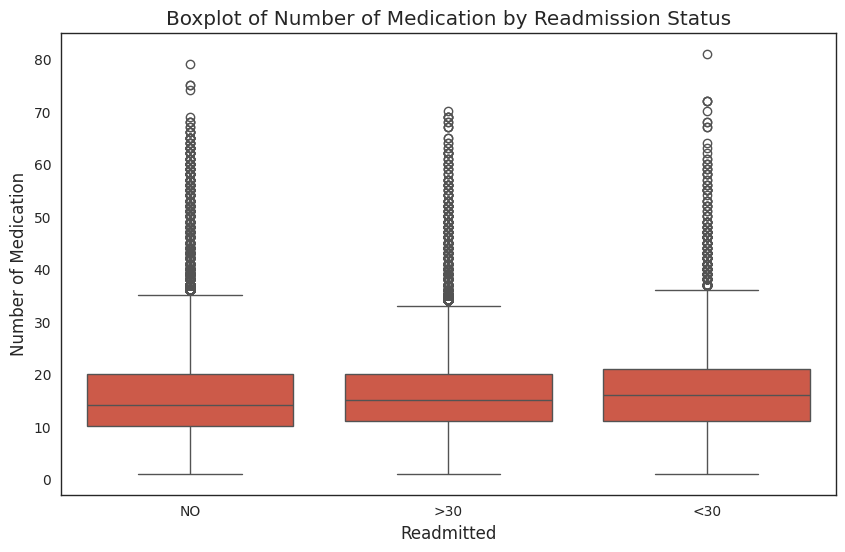

In [71]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=diabetic_data, x='readmitted', y='num_medications')

# Add labels and title
plt.title('Boxplot of Number of Medication by Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('Number of Medication')

# Show the plot
plt.show()

For **num_lab_procedures**, there is no visible correlation with readmission.

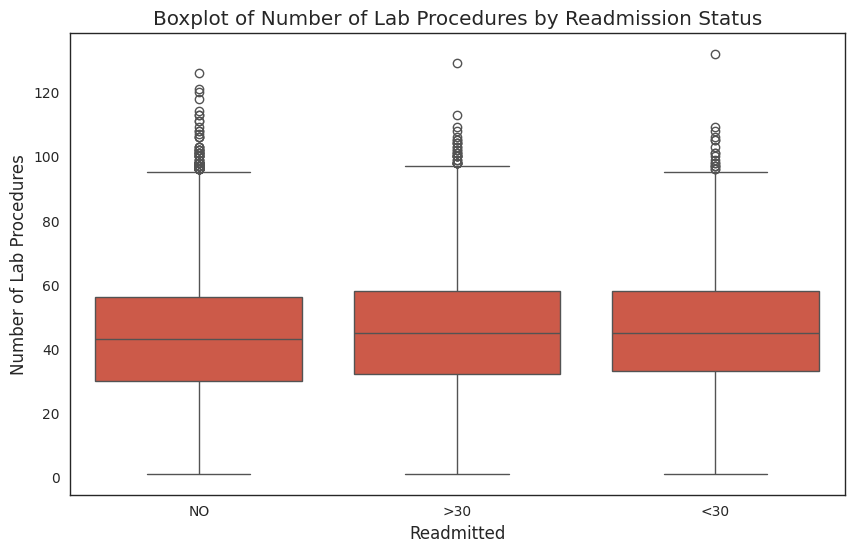

In [72]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=diabetic_data, x='readmitted', y='num_lab_procedures')

# Add labels and title
plt.title('Boxplot of Number of Lab Procedures by Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('Number of Lab Procedures')

# Show the plot
plt.show()

For **num_procedures**, there is no visible correlation with readmission.

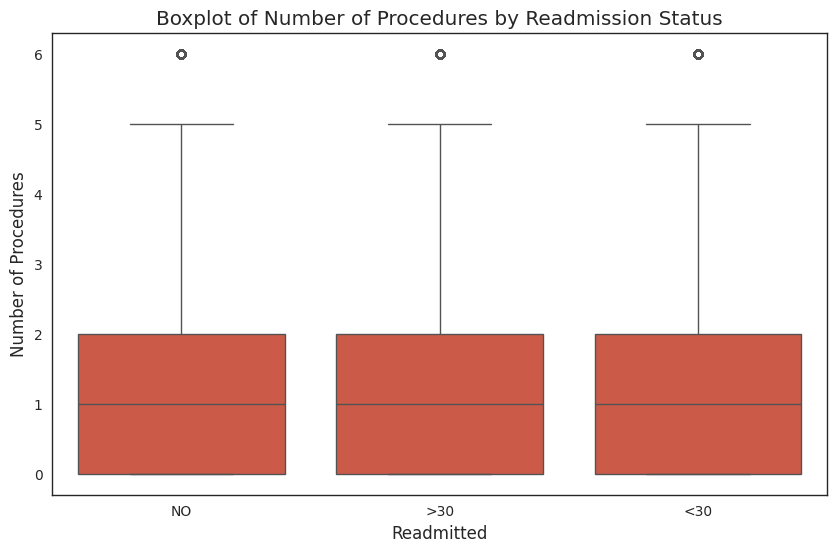

In [73]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=diabetic_data, x='readmitted', y='num_procedures')

# Add labels and title
plt.title('Boxplot of Number of Procedures by Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('Number of Procedures')

# Show the plot
plt.show()

For **time_in_hospital**, there is no visible correlation with readmission.

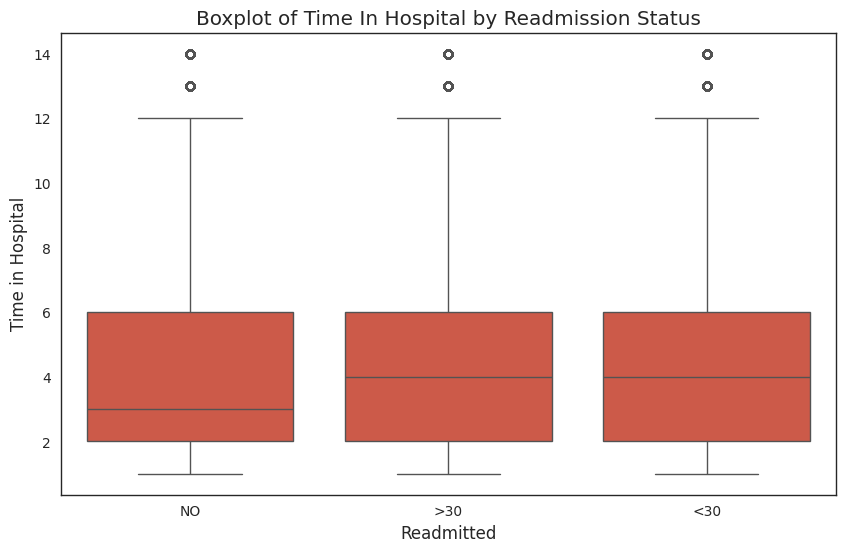

In [74]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=diabetic_data, x='readmitted', y='time_in_hospital')

# Add labels and title
plt.title('Boxplot of Time In Hospital by Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('Time in Hospital')

# Show the plot
plt.show()

For **number_inpatient**, positive correlation is immediately noticeable.

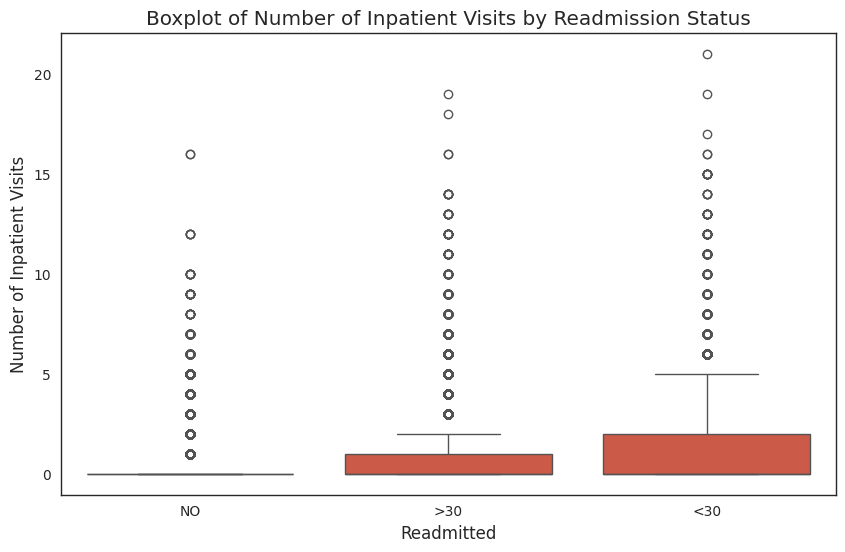

In [75]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=diabetic_data, x='readmitted', y='number_inpatient')

# Add labels and title
plt.title('Boxplot of Number of Inpatient Visits by Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('Number of Inpatient Visits')

# Show the plot
plt.show()

For **number_outpatient**, there is no visible correlation with readmission. By the looks of it, it's not even worth it to handle outlier values.

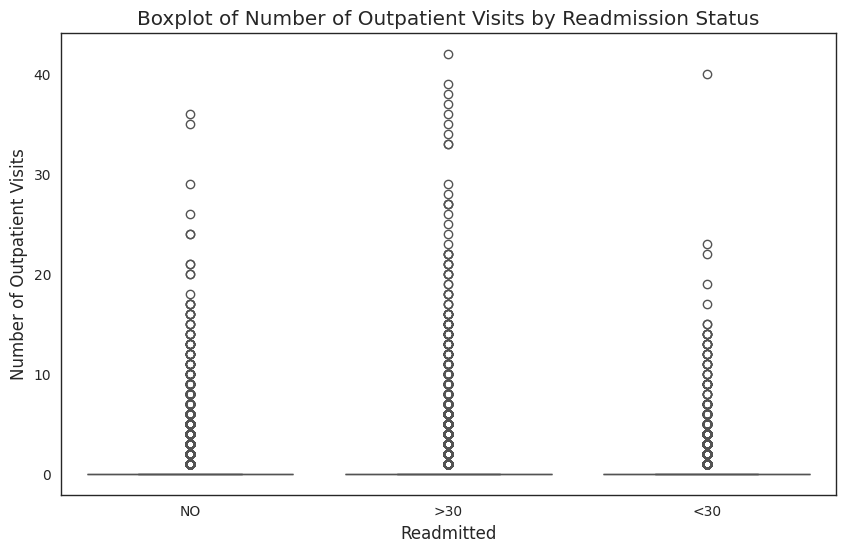

In [76]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=diabetic_data, x='readmitted', y='number_outpatient')

# Add labels and title
plt.title('Boxplot of Number of Outpatient Visits by Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('Number of Outpatient Visits')

# Show the plot
plt.show()

For **number_emergency**, there is no visible correlation with readmission. By the looks of it, it's not even worth it to handle outlier values.

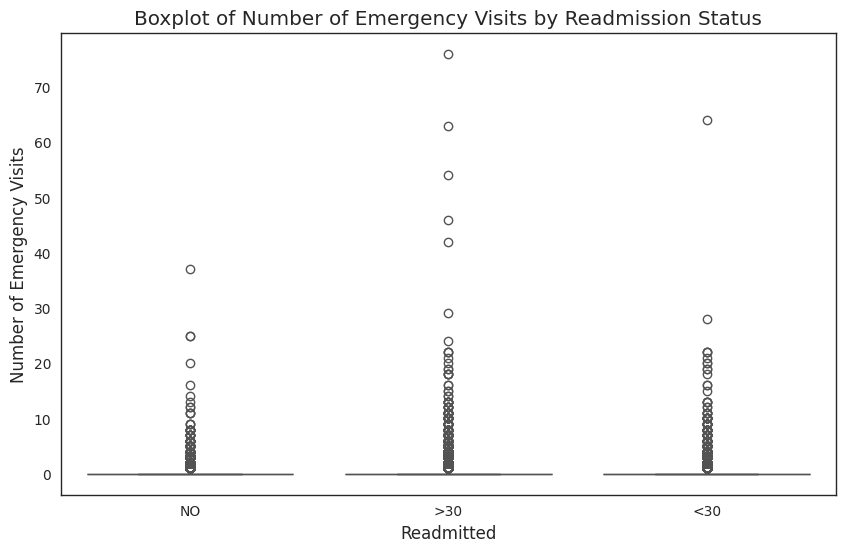

In [77]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=diabetic_data, x='readmitted', y='number_emergency')

# Add labels and title
plt.title('Boxplot of Number of Emergency Visits by Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('Number of Emergency Visits')

# Show the plot
plt.show()

For **medication_change**, there is a small correlation with readmissions. A change in medication seems to lead to easier readmission.

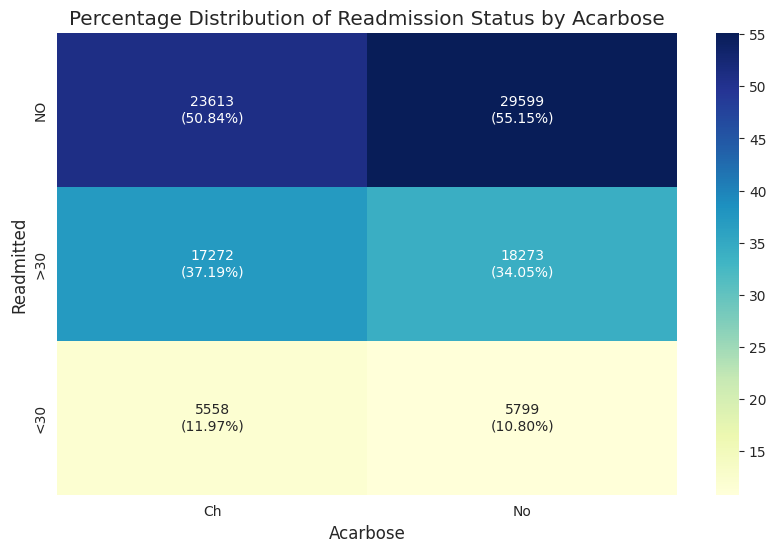

In [78]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='change',
    y='readmitted',
    rows=['NO', '>30', '<30'],
    # columns=['No', 'Down', 'Steady', 'Up']
)


plt.title('Percentage Distribution of Readmission Status by Acarbose')
plt.xlabel('Acarbose')
plt.ylabel('Readmitted')
plt.show()

For **diabetes_medication**, there is a small correlation with readmissions. Subministration of diabetes medications seems to lead to easier readmission.

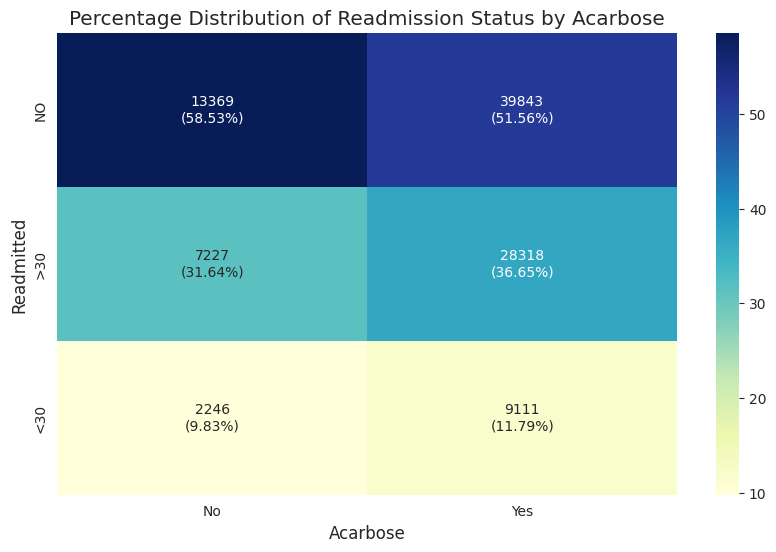

In [79]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='diabetesMed',
    y='readmitted',
    rows=['NO', '>30', '<30'],
    # columns=['No', 'Down', 'Steady', 'Up']
)


plt.title('Percentage Distribution of Readmission Status by Acarbose')
plt.xlabel('Acarbose')
plt.ylabel('Readmitted')
plt.show()

For **medical specialty**... **EVALUATE FURTHER**

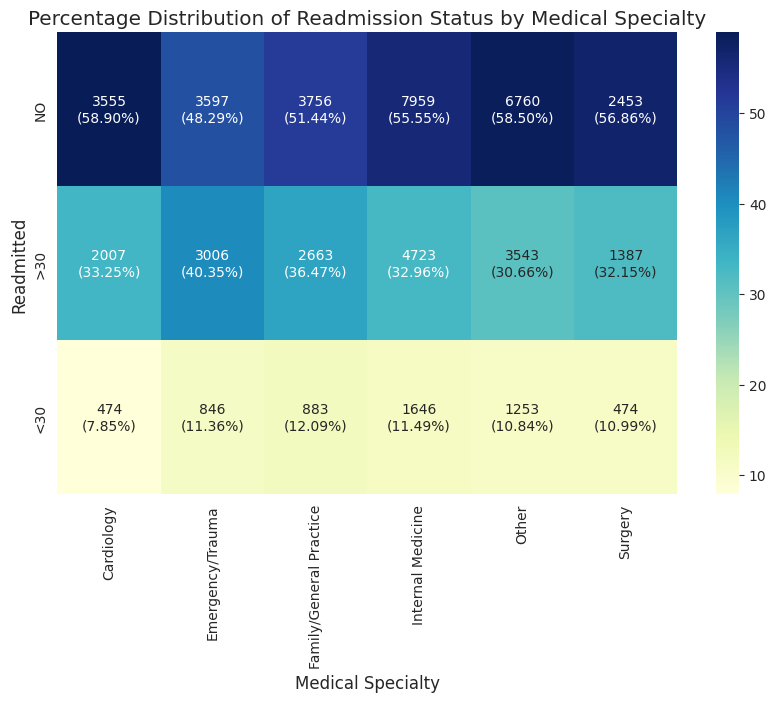

In [80]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='medical_specialty_group',
    y='readmitted',
    rows=['NO', '>30', '<30'],
    # columns=['No', 'Down', 'Steady', 'Up']
)


plt.title('Percentage Distribution of Readmission Status by Medical Specialty')
plt.xlabel('Medical Specialty')
plt.ylabel('Readmitted')
plt.show()

For **primary_diagnosis**... **EVALUATE FURTHER**

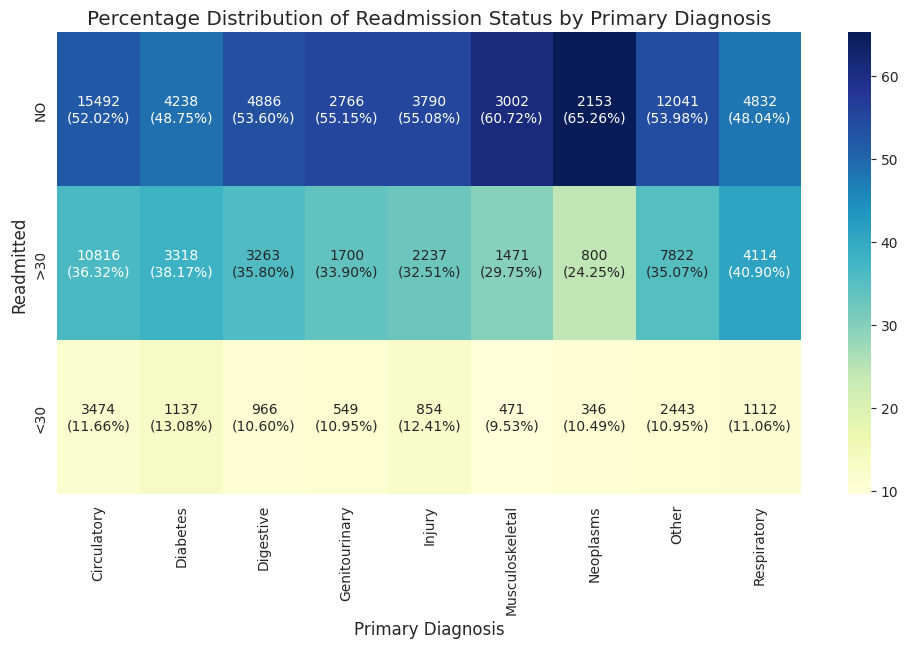

In [81]:
plt.figure(figsize=(12, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='diag_1_group',
    y='readmitted',
    rows=['NO', '>30', '<30'],
    # columns=['No', 'Down', 'Steady', 'Up']
)


plt.title('Percentage Distribution of Readmission Status by Primary Diagnosis')
plt.xlabel('Primary Diagnosis')
plt.ylabel('Readmitted')
plt.show()

For **secondary_diagnosis**... **EVALUATE FURTHER**

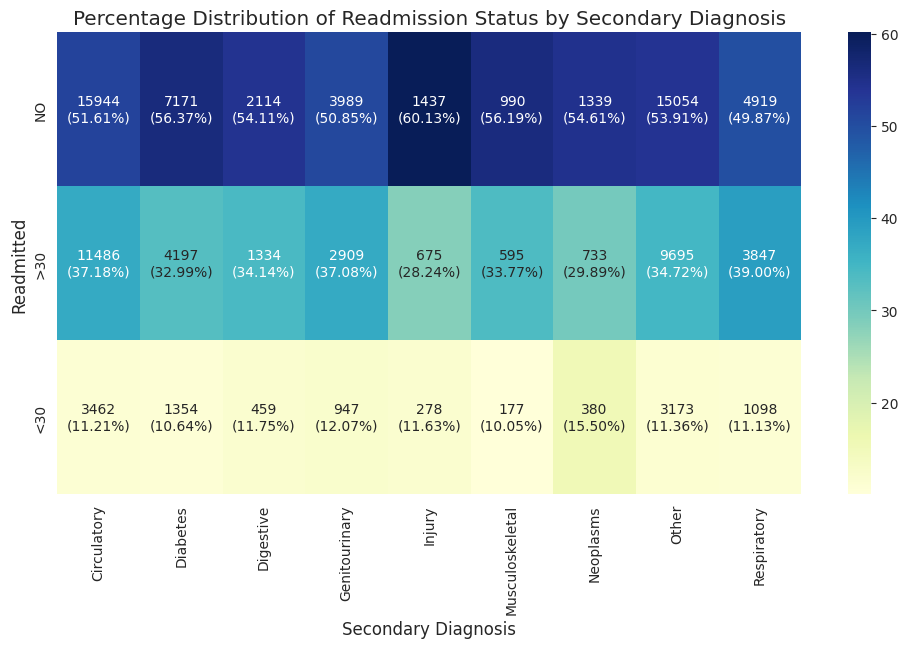

In [82]:
plt.figure(figsize=(12, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='diag_2_group',
    y='readmitted',
    rows=['NO', '>30', '<30'],
    # columns=['No', 'Down', 'Steady', 'Up']
)


plt.title('Percentage Distribution of Readmission Status by Secondary Diagnosis')
plt.xlabel('Secondary Diagnosis')
plt.ylabel('Readmitted')
plt.show()

For **tertiary_diagnosis**... **EVALUATE FURTHER**

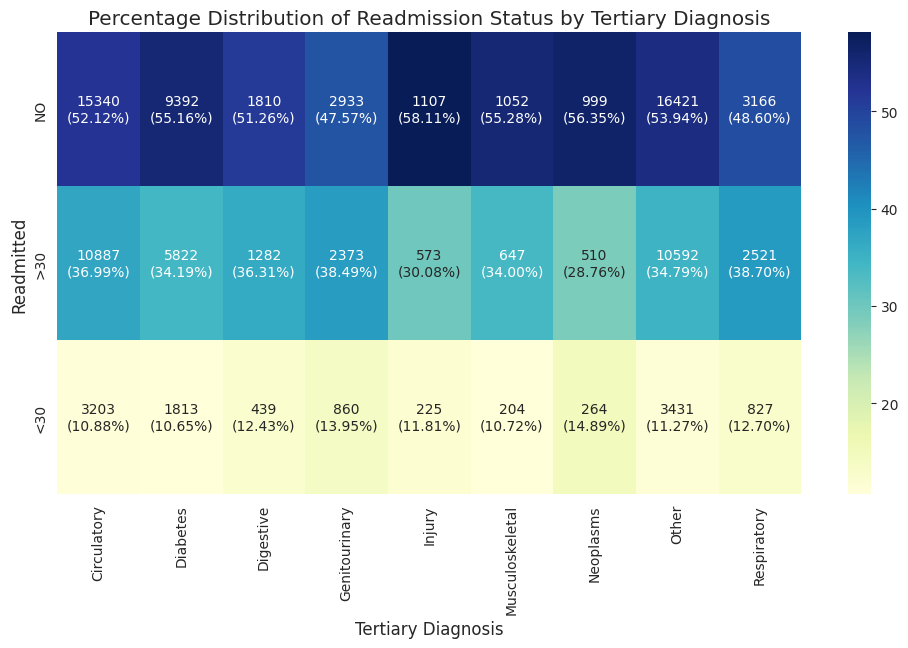

In [83]:
plt.figure(figsize=(12, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='diag_3_group',
    y='readmitted',
    rows=['NO', '>30', '<30'],
    # columns=['No', 'Down', 'Steady', 'Up']
)


plt.title('Percentage Distribution of Readmission Status by Tertiary Diagnosis')
plt.xlabel('Tertiary Diagnosis')
plt.ylabel('Readmitted')
plt.show()

For **admission_type**, there is no visible correlation with readmissions.

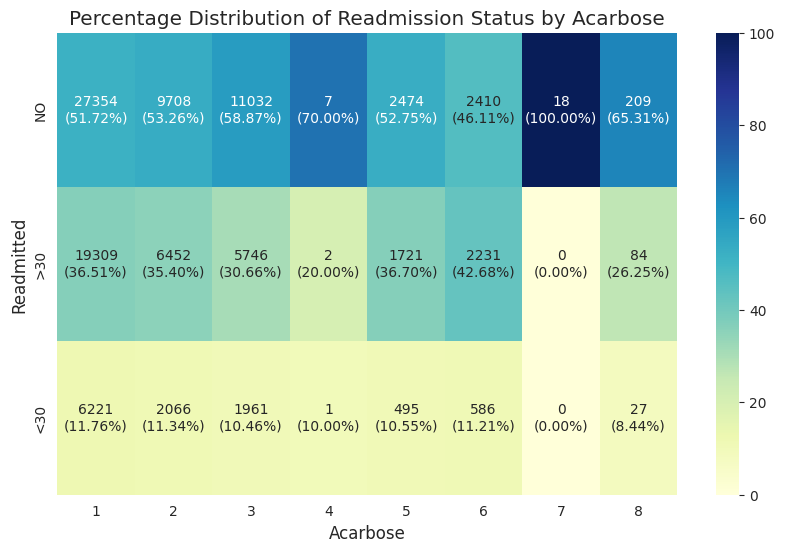

In [84]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='admission_type_id',
    y='readmitted',
    rows=['NO', '>30', '<30'],
    # columns=['No', 'Down', 'Steady', 'Up']
)


plt.title('Percentage Distribution of Readmission Status by Acarbose')
plt.xlabel('Acarbose')
plt.ylabel('Readmitted')
plt.show()

For **admission_source**... **EVALUATE FURTHER**

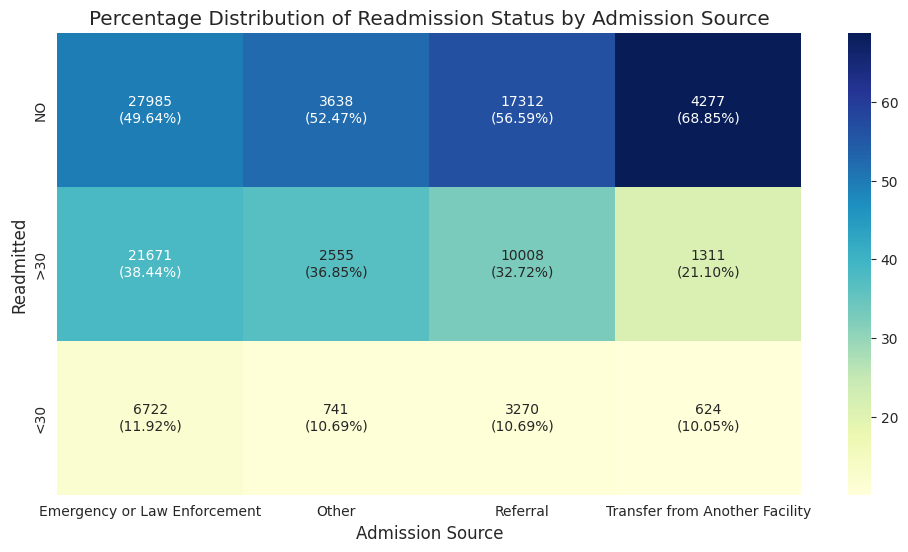

In [85]:
plt.figure(figsize=(12, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='admission_source_group',
    y='readmitted',
    rows=['NO', '>30', '<30'],
    # columns=['No', 'Down', 'Steady', 'Up']
)


plt.title('Percentage Distribution of Readmission Status by Admission Source')
plt.xlabel('Admission Source')
plt.ylabel('Readmitted')
plt.show()

For **discharge_disposition**... **EVALUATE FURTHER**

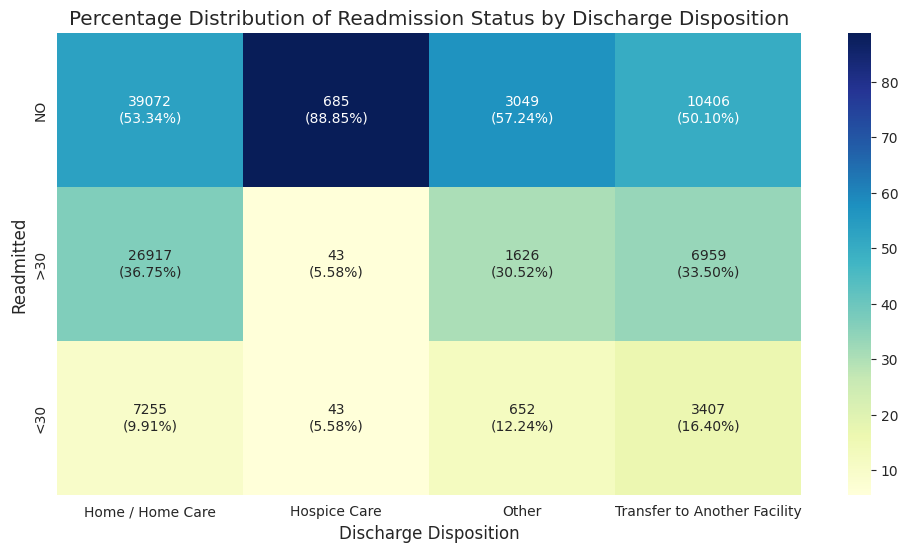

In [86]:
plt.figure(figsize=(12, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='discharge_disposition_group',
    y='readmitted',
    rows=['NO', '>30', '<30'],
    # columns=['No', 'Down', 'Steady', 'Up']
)


plt.title('Percentage Distribution of Readmission Status by Discharge Disposition')
plt.xlabel('Discharge Disposition')
plt.ylabel('Readmitted')
plt.show()

#### 2.2.2 Medication features (CONTROLLARE NEL DATASET ESISTENZA MEDICAZIONI)

For **insulin**, if you leave unmodified, everything is fine... if you change the dosage, shit hits the fan.

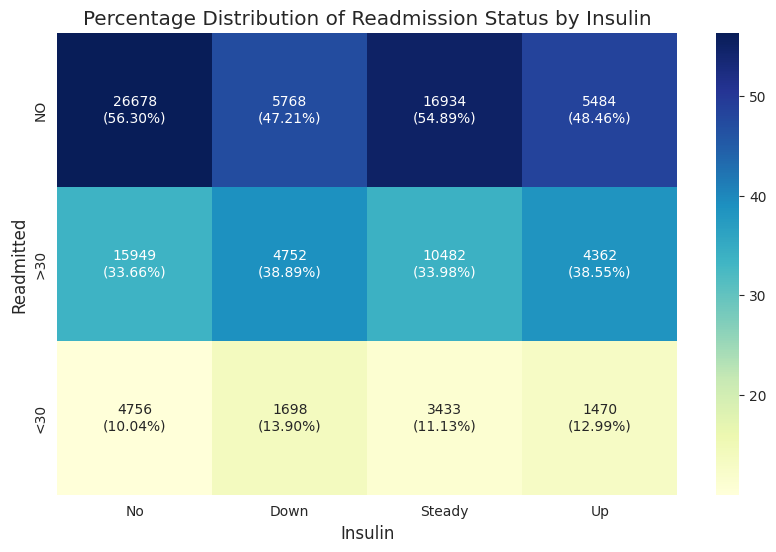

In [125]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='insulin',
    y='readmitted',
    rows=['NO', '>30', '<30'],
    columns=['No', 'Down', 'Steady', 'Up']
)

plt.title('Percentage Distribution of Readmission Status by Insulin')
plt.xlabel('Insulin')
plt.ylabel('Readmitted')
plt.show()

For **Sulfonylureas**, there were too few administrations, and for those that had the most subministrations, there wasn't any visible difference between readmitted and not readmitted.

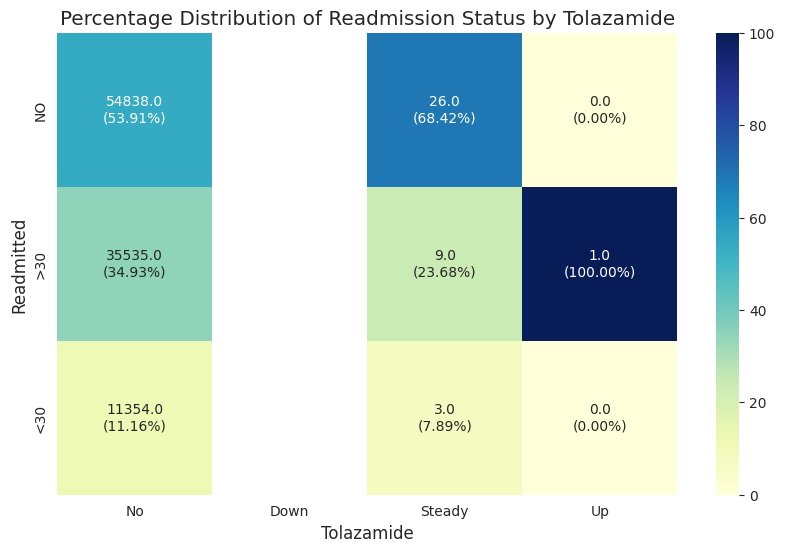

In [126]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='tolazamide',
    y='readmitted',
    rows=['NO', '>30', '<30'],
    columns=['No', 'Down', 'Steady', 'Up']
)

plt.title('Percentage Distribution of Readmission Status by Tolazamide')
plt.xlabel('Tolazamide')
plt.ylabel('Readmitted')
plt.show()

For **TZDs**, there were any visible difference between readmitted and not readmitted.

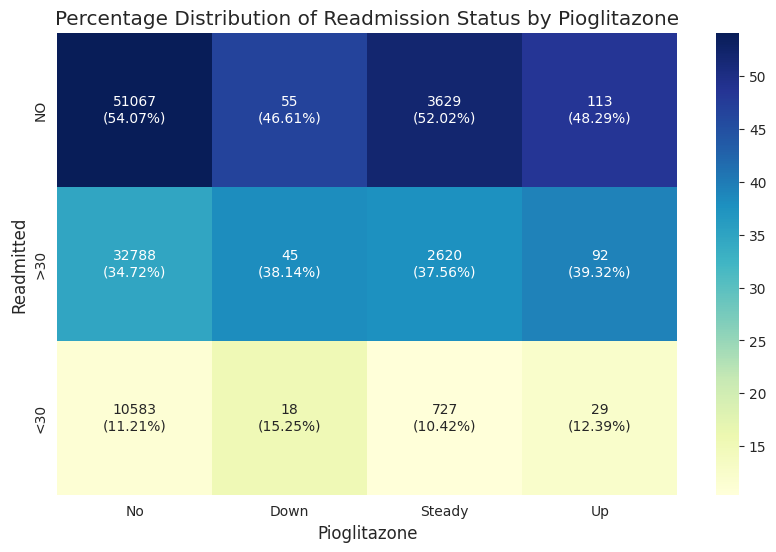

In [127]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='pioglitazone',
    y='readmitted',
    rows=['NO', '>30', '<30'],
    columns=['No', 'Down', 'Steady', 'Up']
)


plt.title('Percentage Distribution of Readmission Status by Pioglitazone')
plt.xlabel('Pioglitazone')
plt.ylabel('Readmitted')
plt.show()

For **combination_medications**, this dataset sucks ass.

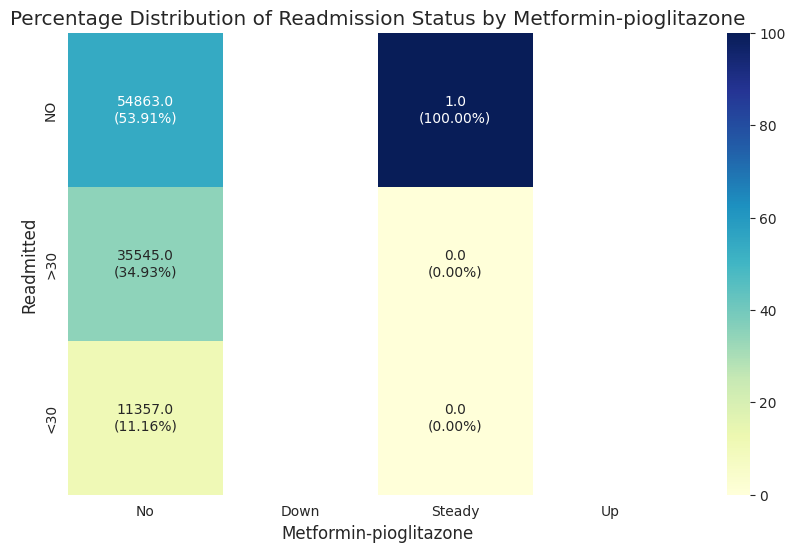

In [128]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='metformin-pioglitazone',
    y='readmitted',
    rows=['NO', '>30', '<30'],
    columns=['No', 'Down', 'Steady', 'Up']
)


plt.title('Percentage Distribution of Readmission Status by Metformin-pioglitazone')
plt.xlabel('Metformin-pioglitazone')
plt.ylabel('Readmitted')
plt.show()

For **metmorfin**, there is no visible correlation whatsover...

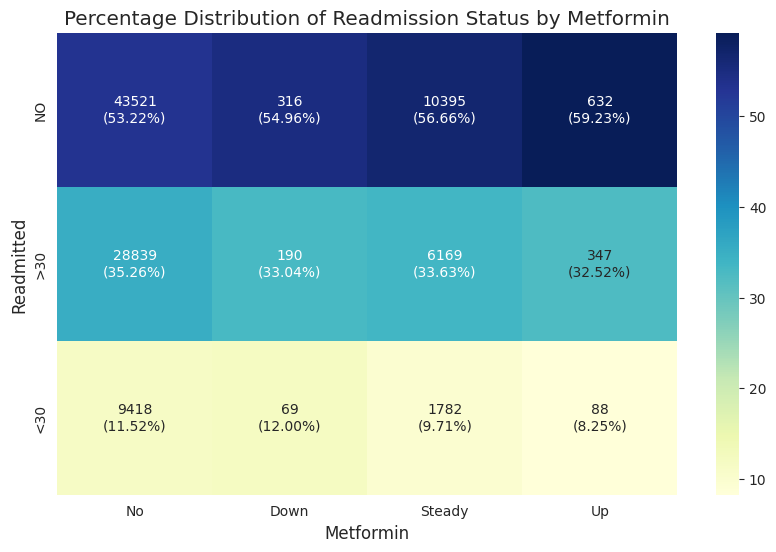

In [129]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='metformin',
    y='readmitted',
    rows=['NO', '>30', '<30'],
    columns=['No', 'Down', 'Steady', 'Up']
)

plt.title('Percentage Distribution of Readmission Status by Metformin')
plt.xlabel('Metformin')
plt.ylabel('Readmitted')
plt.show()

For **troglitazone**, no sufficient data is available.

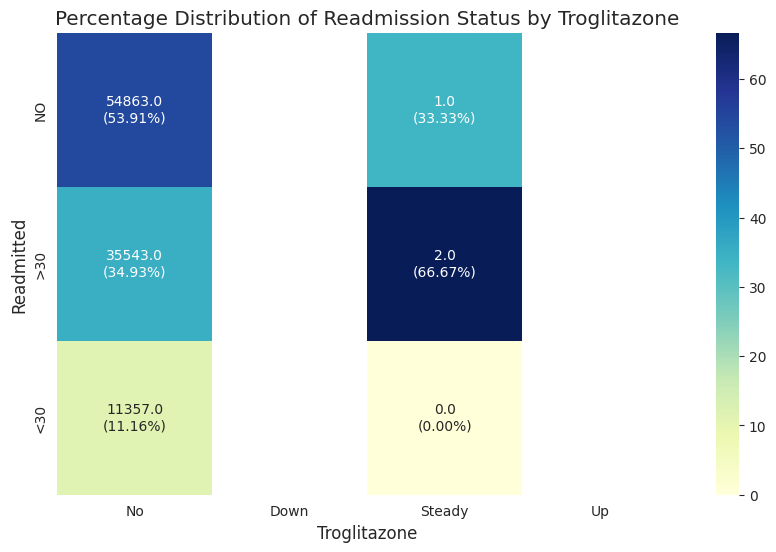

In [130]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='troglitazone',
    y='readmitted',
    rows=['NO', '>30', '<30'],
    columns=['No', 'Down', 'Steady', 'Up']
)


plt.title('Percentage Distribution of Readmission Status by Troglitazone')
plt.xlabel('Troglitazone')
plt.ylabel('Readmitted')
plt.show()

For **repaglinide**, there are very few subministrations, but when they happen it seems to lead to easier readmission.

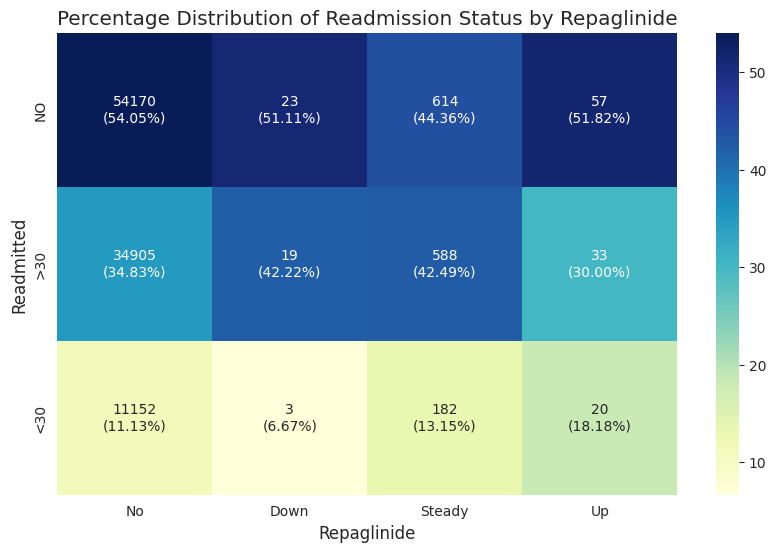

In [131]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='repaglinide',
    y='readmitted',
    rows=['NO', '>30', '<30'],
    columns=['No', 'Down', 'Steady', 'Up']
)


plt.title('Percentage Distribution of Readmission Status by Repaglinide')
plt.xlabel('Repaglinide')
plt.ylabel('Readmitted')
plt.show()

For **nateglinide**, there is no real correlation visible, and very few subministrations overall.

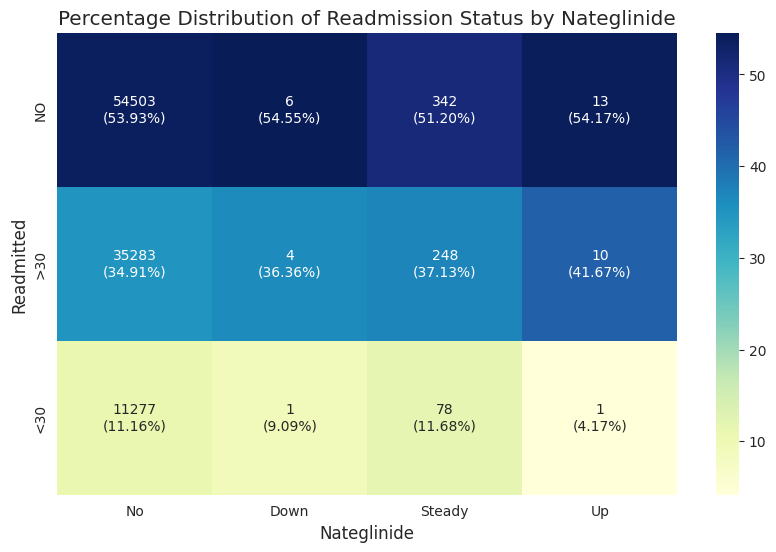

In [132]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='nateglinide',
    y='readmitted',
    rows=['NO', '>30', '<30'],
    columns=['No', 'Down', 'Steady', 'Up']
)


plt.title('Percentage Distribution of Readmission Status by Nateglinide')
plt.xlabel('Nateglinide')
plt.ylabel('Readmitted')
plt.show()

For **examide**, well...

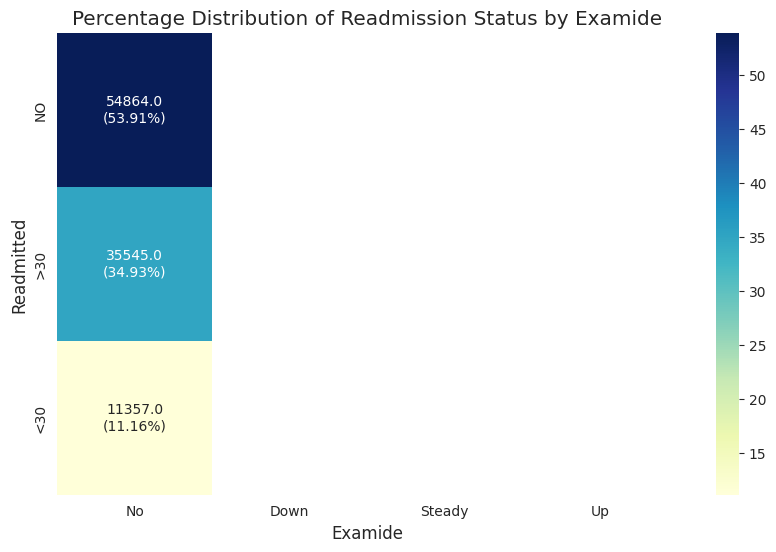

In [133]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='examide',
    y='readmitted',
    rows=['NO', '>30', '<30'],
    columns=['No', 'Down', 'Steady', 'Up']
)


plt.title('Percentage Distribution of Readmission Status by Examide')
plt.xlabel('Examide')
plt.ylabel('Readmitted')
plt.show()

For **acarbose**, since there were too few instances, probably it's not very important, so we can remove it from the dataset.

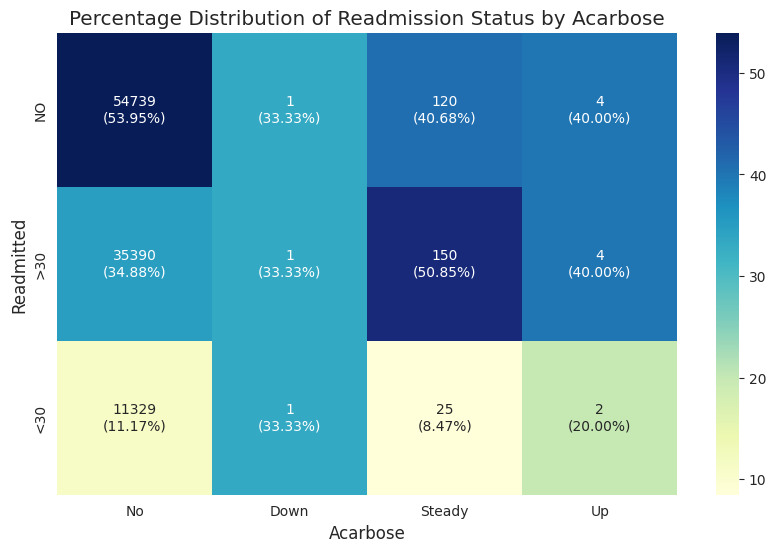

In [134]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='acarbose',
    y='readmitted',
    rows=['NO', '>30', '<30'],
    columns=['No', 'Down', 'Steady', 'Up']
)


plt.title('Percentage Distribution of Readmission Status by Acarbose')
plt.xlabel('Acarbose')
plt.ylabel('Readmitted')
plt.show()

For **miglitol**, since there were too few instances, probably it's not very important, so we can remove it from the dataset.

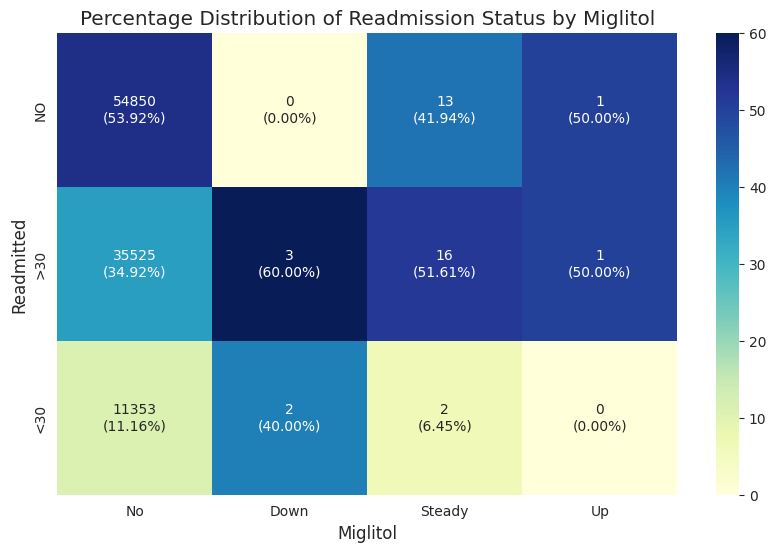

In [135]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='miglitol',
    y='readmitted',
    rows=['NO', '>30', '<30'],
    columns=['No', 'Down', 'Steady', 'Up']
)


plt.title('Percentage Distribution of Readmission Status by Miglitol')
plt.xlabel('Miglitol')
plt.ylabel('Readmitted')
plt.show()